In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [10]:
pb_dir_path = './results/'

In [11]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [13]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [14]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

### Create dataframe

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]

In [17]:
df.head()

,AACS,AAGAB,AAK1,AAMP,AAR2,AARS1,AARS2,AASDH,AASDHPPT,AATF,...,ZNFX1,ZNHIT3,ZNRD2,ZNRF1,ZPR1,ZRANB2,ZSCAN18,ZSCAN21,ZUP1,ZZZ3
human_759_WM,0.041268,0.025707,-0.072019,0.051644,-0.040637,0.007453,-0.047439,0.013681,-0.112373,-0.027305,...,0.002537,-0.145321,-0.012920,-0.019393,0.010821,0.002873,0.018861,0.032487,-0.083505,-0.040384
human_j12_WM,0.025153,-0.044543,0.001885,0.044115,-0.005605,0.064853,-0.020012,0.036537,-0.247531,0.059761,...,0.029141,-0.053724,0.029411,-0.080373,-0.068238,-0.011533,-0.072855,-0.043932,-0.005179,0.055280
human_j3_WM,-0.028083,-0.011412,0.121080,-0.036493,-0.043526,-0.017252,-0.003079,0.047993,-0.150683,0.065300,...,0.026583,-0.017077,0.022215,-0.106516,0.025459,0.008847,-0.013096,-0.029365,0.055279,0.020677
human_j4_WM,-0.020194,-0.054054,0.040012,-0.023853,0.081220,0.055494,-0.012639,-0.001961,-0.177060,0.061381,...,0.055548,-0.082023,0.017378,-0.073447,0.030231,-0.000191,-0.116543,-0.023978,0.012403,0.078987
human_j6_WM,0.004524,0.010688,0.078731,0.049893,-0.014778,-0.074468,-0.035236,-0.024390,0.091938,0.022454,...,-0.049726,-0.146974,0.022209,0.003881,0.070576,0.027428,-0.033470,-0.019749,0.130150,0.027191


In [18]:
df_cont = df.copy()
df_cont['condition'] = adata_pb_norm.obs.condition
df_cont['layer'] = adata_pb_norm.obs.layer
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)
df_cont['intercept'] = 1

In [19]:
df_cont.columns = df_cont.columns.str.replace('-', '')

In [20]:
p_val_dict = dict()
for specie in ['human', 'chimp', 'macaque']:
    p_val_list = []
    for gene in tqdm(df_cont.columns[:-3]):
        formula = f'{gene} ~ layer + layer ^ 2 + layer ^ 3'
        subs_index = df_cont[df_cont.condition == specie].index
        model = ols(formula, data=df_cont, subset=subs_index).fit()
        p_val_list.append(model.f_pvalue)
    p_val_dict[specie] = p_val_list

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

In [21]:
results = pd.DataFrame(p_val_dict, index=df.columns)
results.head()

,human,chimp,macaque
AACS,0.001206,0.014287,0.318736
AAGAB,0.731575,0.661344,0.024143
AAK1,0.000658,0.699175,0.069657
AAMP,0.762617,0.530339,0.947528
AAR2,0.312623,0.436571,0.343371


In [22]:
results.to_csv('gene_selection_df.csv')

In [24]:
from itertools import permutations

res_dict = dict()
conditions = ['human', 'chimp', 'macaque']
permut = list(permutations(conditions, 2))

for ref_specie, sec_specie in permut:
    res_list = []
    not_const_genes = results[results[ref_specie] < 0.05].index
    for gene in tqdm(df_cont.columns[:-3]):
        subs_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
        df_cont_sub = df_cont.loc[subs_index].copy()
        df_cont_sub.condition = df_cont_sub.condition.astype(str)
        
        formula1 = f'{gene} ~ layer + layer ^ 2 + layer ^ 3'
        model1 = ols(formula, data=df_cont_sub).fit()
        
        formula2 = f'{gene} ~ (layer + layer ^ 2 + layer ^ 3) * condition'
        model2 = ols(formula2, data=df_cont_sub).fit()

        res_list.append(model2.compare_f_test(model1))
    res_dict[f'{ref_specie}-{sec_specie}'] = pd.DataFrame(res_list, columns=['F-score', 'p-value', 'df'], index=df.columns)

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

In [25]:
res_df = res_dict['human-chimp']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
ABCG4,3.147098,0.021465,4.0
ADAL,3.720984,0.009653,4.0
ALG12,3.167152,0.020871,4.0
ANAPC2,11.244549,0.000001,4.0
ANAPC4,3.458951,0.013885,4.0
...,...,...,...
ZNF184,2.744382,0.037813,4.0
ZNF213,7.805032,0.000051,4.0
ZNF341,6.125881,0.000397,4.0
ZNF510,8.514597,0.000022,4.0


In [26]:
res_df = res_dict['human-macaque']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
AAR2,4.282599,4.350855e-03,4.0
AARS2,10.274217,2.762764e-06,4.0
AASDH,2.664911,4.186185e-02,4.0
AATF,2.656381,4.237143e-02,4.0
ABCB9,6.192262,3.459642e-04,4.0
...,...,...,...
ZNF654,14.541034,3.655513e-08,4.0
ZNF668,6.603258,2.053457e-04,4.0
ZNF76,11.499081,7.459039e-07,4.0
ZNF768,11.224491,9.953096e-07,4.0


<Axes: >

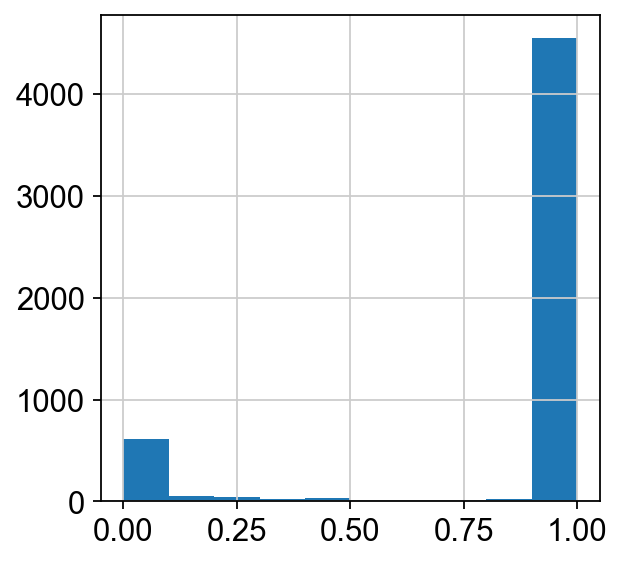

In [28]:
res_df['p-value'].hist()

In [27]:
import pickle

with open('results/ancova_res.pkl', 'wb') as f:
    pickle.dump(res_dict, f)